In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

import stateinterpreter.MD 

## Loader

In [10]:
from stateinterpreter.MD import Loader

folder = "data/chignolin-v3/"

file_dict = {
    'trajectory': 'CLN025-0-protein-ALL.dcd',
    'topology' : 'CLN025-0-protein.pdb',
    'collective_vars': 'COLVAR'
}
stride = 10
data = Loader(folder, file_dict, stride=stride,_DEV=False)

# Rename TICA CVs
data.colvar = data.colvar.rename(columns={'deep.node-4': 'tica1','deep.node-3': 'tica2','deep.node-2': 'tica3', 'deep.node-1': 'tica4','deep.node-0': 'tica5'})

## Define states based on FES minima

In [11]:
# Collective variables used for classes identification
collective_vars = ['tica1', 'tica2'] #, 'tica3']
bounds = [(-1.1,1.1)]*len(collective_vars)

colvar = data.load(collective_vars, bounds, num=50, memory_saver=False, )

colvar.to_csv(folder+'dataframe',sep=' ')

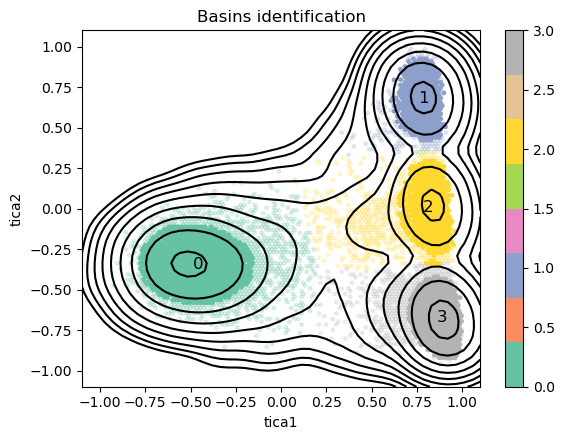

In [13]:
basins = colvar['basin'].unique()

def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my
    
# scatter plot of tica components 
pairs = [['tica1','tica2']]# ,['tica1','tica3'],['tica2','tica3']]

fig, axs = plt.subplots(1,len(pairs),figsize=(6*len(pairs),4.5),dpi=100)
for k,(label_x,label_y) in enumerate(pairs):
    # select ax
    ax = axs[k] if len(pairs) > 1 else axs

    # FES isolines (if 2D)
    if data.FES[1].ndim == 2:
        sampled_positions, f = data.FES

        xx = sampled_positions[0]
        yy = sampled_positions[1]
        cset = ax.contour(xx, yy, f, levels=np.linspace(1,30,10), colors='k')

    # hexbin plot
    colvar.plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax,alpha=0.2,colorbar=False)
    pp = colvar[colvar['selection']].plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax)
    ax.set_title('Basins identification')

    #add basins labels
    for b in basins:
        mx,my = compute_basin_mean(colvar,b,label_x,label_y)
        text = ax.text(mx, my, b, ha="center", va="center", 
                       color="k", fontsize='large')

plt.tight_layout()

## State interpreter

In [14]:
from stateinterpreter.classifier import MD_Data, CV_path

colvar = pd.read_csv(folder+'dataframe', sep=' ')
model = MD_Data(colvar)

# input features
select_feat = 'sin_|cos_'
sample = model.sample(1000, regex_filter = select_feat)

### Linear kernel

In [53]:
C_range = np.geomspace(2, 100, 25)
kwargs = {'LASSO':True, 'max_iter':1000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

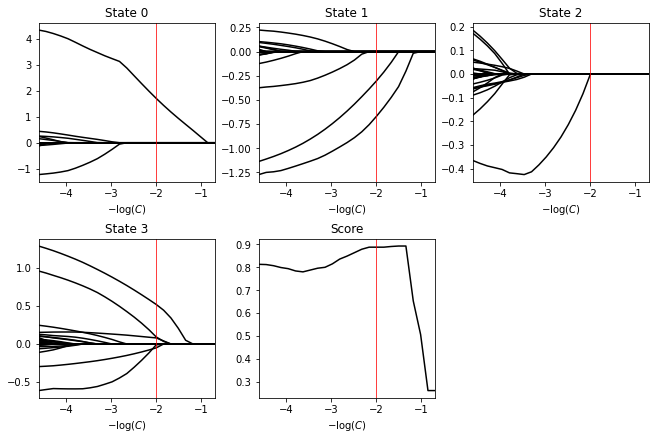

State 0:
	 100.0% | SIDECHAIN cos_chi1 ASP3
State 1:
	 83.0% | SIDECHAIN cos_chi1 THR8
	 17.0% | SIDECHAIN sin_chi1 THR6
State 2:
	 100.0% | SIDECHAIN cos_chi1 ASP3
State 3:
	 93.9% | SIDECHAIN sin_chi1 THR6
	 3.0%  | SIDECHAIN cos_chi1 THR8
	 2.2%  | BACKBONE sin_psi THR8
	 0.9%  | SIDECHAIN sin_chi1 THR8
	 0.0%  | SIDECHAIN cos_chi1 ASP3
-- UNIQUE FEATURES --


{'BACKBONE sin_psi THR8',
 'SIDECHAIN cos_chi1 ASP3',
 'SIDECHAIN cos_chi1 THR8',
 'SIDECHAIN sin_chi1 THR6',
 'SIDECHAIN sin_chi1 THR8'}

In [54]:
C = np.exp(2.)
cvpath.plot(C)
plt.show()
cvpath.print_relevant_features(C)

print('-- UNIQUE FEATURES --')
relevant_feat = cvpath.relevant_features(C)

unique_features = set()
for state in relevant_feat.values():
    for feat in state:
        unique_features.add(feat[1])

unique_features

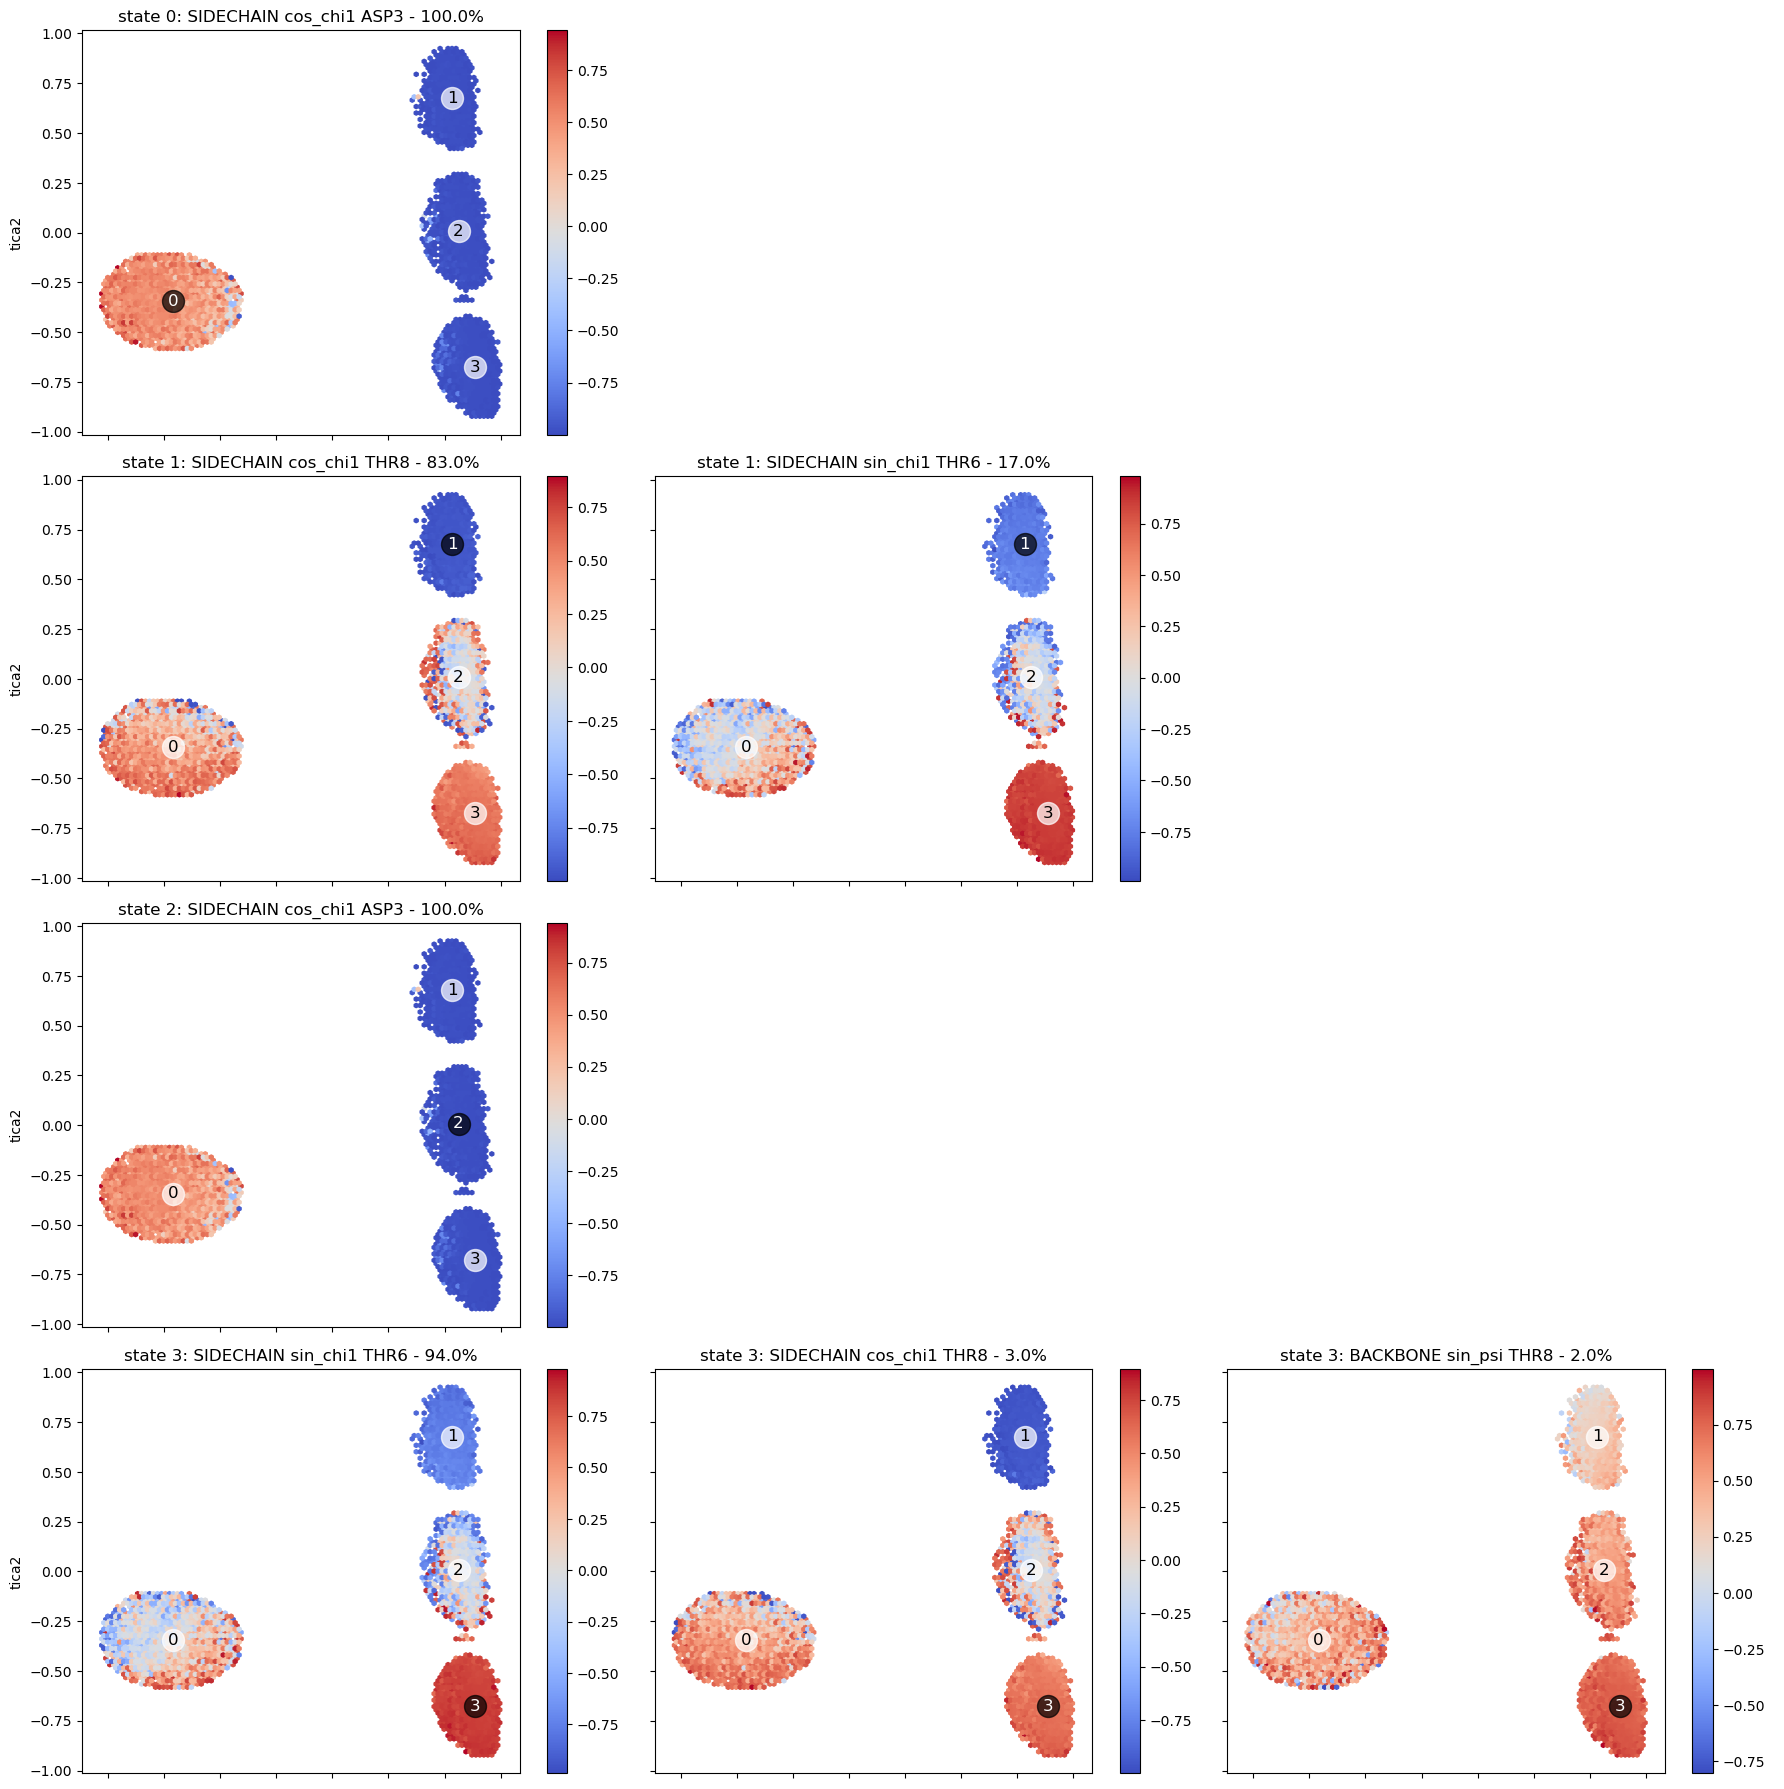

In [55]:
# PLOT FEATURES vs TICAs

# check maximum number of relevant features per state
#max_nfeat = max(len(feat_i) for feat_i in relevant_feat.values())
max_nfeat = 3

# aux function to compute basins mean
def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my

# retrieve basins
basins = colvar['basin'].unique()
n_basins = len(basins)

# scatter plot of tica components 
pairs = [['tica1','tica2']]
label_x,label_y = pairs[0]

fig, axs = plt.subplots(n_basins,max_nfeat,figsize=(6 * max_nfeat, 4.5* n_basins),dpi=100, sharex=True, sharey=True)

for i,(state,feat_list) in enumerate(relevant_feat.items()):
    for j,feat_array in enumerate(feat_list):
        if j < max_nfeat:
            feat = feat_array[1]
            importance = feat_array[2]
            ax = axs[i,j]
            pp = colvar[colvar['selection']==1].plot.hexbin(label_x,label_y,C=feat,cmap='coolwarm',ax=ax)
            ax.set_title(f'state {state}: {feat} - {np.round(importance*100)}%')
            #add basins labels
            for b in basins:
                mx,my = compute_basin_mean(colvar,b,label_x,label_y)
                bcolor = 'k' if b == i else 'w'
                fcolor = 'w' if b == i else 'k'            
                ax.scatter(mx,my,color=bcolor,s=250,alpha=0.7)
                text = ax.text(mx, my, b, ha="center", va="center", 
                            color=fcolor, fontsize='large')

    #disable other axis
    for j in range(len(feat_list),max_nfeat):
        axs[i,j].axis('off')

plt.tight_layout()

In [ ]:
# DEPRECATED, see cell above for plotting

basins = colvar['basin'].unique()

# scatter plot of tica components 
pairs = [['tica1','tica2']]#,['tica1','tica3'],['tica2','tica3']]

for feat in unique_features:
    fig, axs = plt.subplots(1,len(pairs),figsize=(6*len(pairs),4.5),dpi=100)
    for k,(label_x,label_y) in enumerate(pairs):
        ax = axs[k] if len(pairs) > 1 else axs
        pp = colvar[colvar['selection']==1].plot.hexbin(label_x,label_y,C=feat,cmap='coolwarm',ax=ax)
        ax.set_title(feat)
        #add basins labels
        for b in basins:
            mx,my = compute_basin_mean(colvar,b,label_x,label_y)
            text = ax.text(mx, my, b, ha="center", va="center", 
                        color="w", fontsize='large')
    plt.tight_layout()

### Quadratic kernel

In [47]:
# Quadratic Kernel

prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);


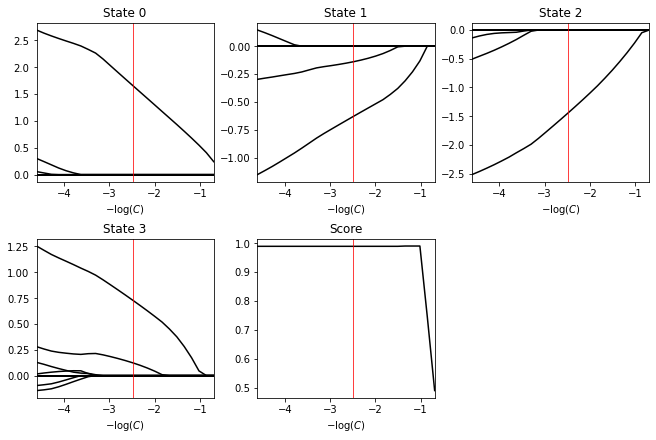

State 0:
	 100.0% | SIDECHAIN cos_chi1 ASP3
State 1:
	 95.3% | SIDECHAIN cos_chi1 THR8
	 4.7%  | SIDECHAIN sin_chi1 THR6
State 2:
	 100.0% | SIDECHAIN sin_chi1 THR6 || SIDECHAIN cos_chi1 THR8
State 3:
	 97.2% | SIDECHAIN sin_chi1 THR6
	 2.8%  | SIDECHAIN cos_chi1 THR8
-- UNIQUE FEATURES --


{'SIDECHAIN cos_chi1 ASP3',
 'SIDECHAIN cos_chi1 THR8',
 'SIDECHAIN sin_chi1 THR6',
 'SIDECHAIN sin_chi1 THR6 || SIDECHAIN cos_chi1 THR8'}

In [48]:
C = np.exp(2.5)
prunedcv.plot(C);
plt.show()
prunedcv.print_relevant_features(C)

print('-- UNIQUE FEATURES --')
relevant_feat = prunedcv.relevant_features(C)

unique_features = set()
for state in relevant_feat.values():
    for feat in state:
        unique_features.add(feat[1])

unique_features

In [49]:
# add quadratic features to fes
for feat in unique_features:
    if "||" in feat:
        if feat not in colvar.columns: 
            i, j = feat.split(' || ')
            feat_ij = colvar[i].values * colvar[j].values
            colvar[feat] = feat_ij

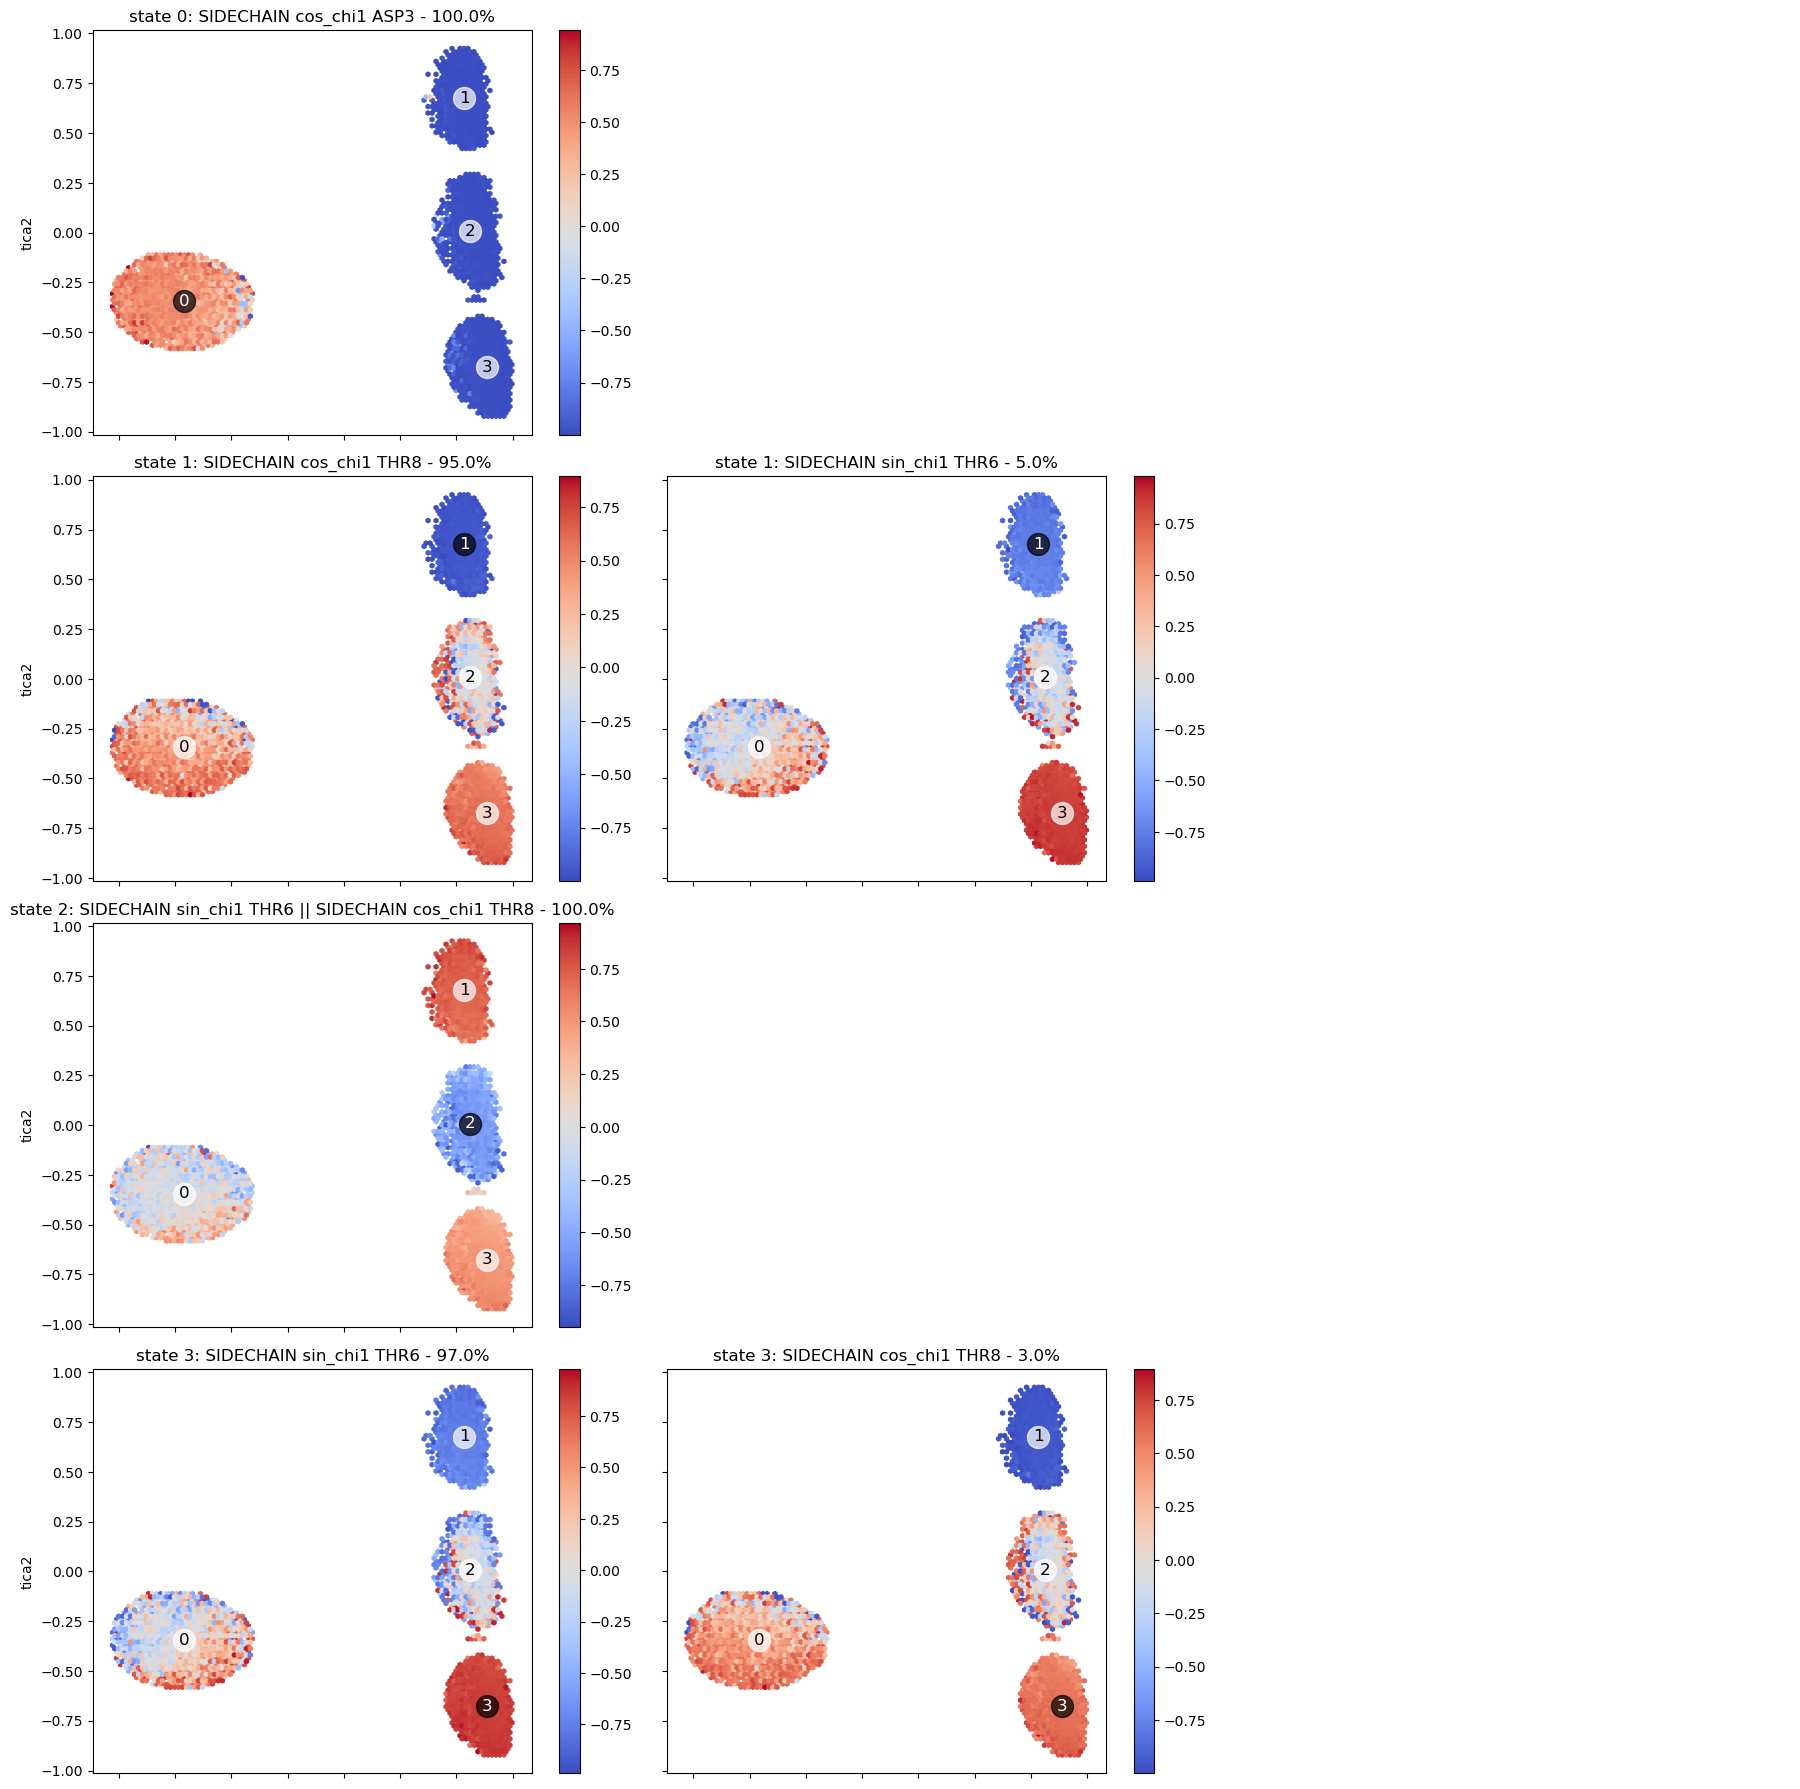

In [52]:
# PLOT FEATURES vs TICAs

# check maximum number of relevant features per state
#max_nfeat = max(len(feat_i) for feat_i in relevant_feat.values())
max_nfeat = 3

# aux function to compute basins mean
def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my

# retrieve basins
basins = colvar['basin'].unique()
n_basins = len(basins)

# scatter plot of tica components 
pairs = [['tica1','tica2']]
label_x,label_y = pairs[0]

fig, axs = plt.subplots(n_basins,max_nfeat,figsize=(6 * max_nfeat, 4.5* n_basins),dpi=100, sharex=True, sharey=True)

for i,(state,feat_list) in enumerate(relevant_feat.items()):
    for j,feat_array in enumerate(feat_list):
        if j < max_nfeat:
            feat = feat_array[1]
            importance = feat_array[2]
            ax = axs[i,j]
            pp = colvar[colvar['selection']==1].plot.hexbin(label_x,label_y,C=feat,cmap='coolwarm',ax=ax)
            ax.set_title(f'state {state}: {feat} - {np.round(importance*100)}%')
            #add basins labels
            for b in basins:
                mx,my = compute_basin_mean(colvar,b,label_x,label_y)
                bcolor = 'k' if b == i else 'w'
                fcolor = 'w' if b == i else 'k'            
                ax.scatter(mx,my,color=bcolor,s=250,alpha=0.7)
                text = ax.text(mx, my, b, ha="center", va="center", 
                            color=fcolor, fontsize='large')

    #disable other axis
    for j in range(len(feat_list),max_nfeat):
        axs[i,j].axis('off')

plt.tight_layout()